In [ ]:
# Import necessary libraries
!pip install numpy scikit-learn tensorflow tqdm python-Levenshtein requests matplotlib

import numpy as np
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Tuple, List
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from Levenshtein import distance as levenshtein_distance


In [ ]:
def load_mnist() -> Tuple[np.ndarray, np.ndarray]:
    """Load digits dataset from scikit-learn's built-in datasets"""
    print("Loading digits dataset from scikit-learn...")
    from sklearn.datasets import load_digits
    digits = load_digits()
    X = digits.data.astype('float32')
    # Normalize to [0,1]
    X = X / X.max()
    y = digits.target
    print(f"Loaded {len(X)} images with {X.shape[1]} features each")
    return X, y


In [ ]:
def euclidean_distance_custom(x1: np.ndarray, x2: np.ndarray) -> float:
    """Custom implementation of euclidean distance"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def euclidean_distance_batched(X: np.ndarray, Y: np.ndarray, batch_size: int = 500) -> np.ndarray:
    """Compute pairwise euclidean distances with batch processing"""
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]
    distances = np.zeros((n_samples_X, n_samples_Y))

    for i in range(0, n_samples_X, batch_size):
        batch_X = X[i:min(i + batch_size, n_samples_X)]
        for j in range(0, n_samples_Y, batch_size):
            batch_Y = Y[j:min(j + batch_size, n_samples_Y)]
            diff = batch_X[:, np.newaxis] - batch_Y
            distances[i:i + batch_X.shape[0], j:j + batch_Y.shape[0]] = np.sqrt(np.sum(diff ** 2, axis=2))

    return distances


In [ ]:
def load_20ng(categories: List[str] = None) -> Tuple[List[str], np.ndarray]:
    """Load 20 Newsgroups dataset"""
    print("Loading 20 Newsgroups dataset from scikit-learn...")
    dataset = fetch_20newsgroups(subset='all',
                               categories=categories,
                               shuffle=True,
                               random_state=42,
                               remove=('headers', 'footers', 'quotes'))
    return dataset.data, dataset.target

def preprocess_20ng_for_similarity(texts: List[str], max_features: int = 5000) -> np.ndarray:
    """Convert texts to TF-IDF vectors"""
    print("Processing 20 Newsgroups texts...")
    vectorizer = TfidfVectorizer(max_features=max_features,
                                stop_words='english',
                                lowercase=True,
                                strip_accents='unicode',
                                norm='l2')

    feature_matrix = vectorizer.fit_transform(texts).toarray()
    return feature_matrix


In [ ]:
def compute_comprehensive_distances(mnist_features: np.ndarray, news_texts: List[str],
                                 news_features: np.ndarray) -> dict:
    """Compute comprehensive distance metrics across all samples"""
    results = {
        'mnist': {},
        'news': {}
    }

    print("Computing MNIST distances...")
    # Use only first 5 samples for demonstration
    results['mnist']['euclidean_matrix'] = euclidean_distance_batched(
        mnist_features[:5],
        mnist_features[:5]
    )

    results['mnist']['stats'] = {
        'mean_euclidean': np.mean(results['mnist']['euclidean_matrix']),
        'std_euclidean': np.std(results['mnist']['euclidean_matrix'])
    }

    print("Computing 20 Newsgroups distances...")
    results['news']['euclidean_matrix'] = euclidean_distance_batched(
        news_features[:5],
        news_features[:5]
    )

    # Compute Levenshtein distances for a small sample
    sample_size = min(1000, len(news_texts))
    edit_distances = np.zeros((sample_size, sample_size))

    for i in tqdm(range(sample_size)):
        for j in range(i+1, sample_size):
            edit_distances[i,j] = levenshtein_distance(news_texts[i], news_texts[j])
            edit_distances[j,i] = edit_distances[i,j]

    results['news']['edit_distances'] = edit_distances
    results['news']['stats'] = {
        'mean_euclidean': np.mean(results['news']['euclidean_matrix']),
        'std_euclidean': np.std(results['news']['euclidean_matrix']),
        'mean_edit': np.mean(edit_distances),
        'std_edit': np.std(edit_distances)
    }

    visualize_distance_distributions(results)
    return results


In [ ]:
def visualize_distance_distributions(results: dict):
    """Visualize the distributions of different distance metrics"""
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.hist(results['mnist']['euclidean_matrix'].flatten(), bins=50)
    plt.title('MNIST Euclidean Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')

    plt.subplot(122)
    plt.hist(results['news']['euclidean_matrix'].flatten(), bins=50)
    plt.title('News Euclidean Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def visualize_results(mnist_results: Tuple[float, float, float],
                     news_results: Tuple[float, float, float]):
    """Visualize classification results"""
    plt.figure(figsize=(12, 5))

    datasets = ['MNIST', '20 Newsgroups']
    train_accs = [mnist_results[0], news_results[0]]
    val_accs = [mnist_results[1], news_results[1]]
    test_accs = [mnist_results[2], news_results[2]]

    x = np.arange(len(datasets))
    width = 0.25

    plt.bar(x - width, train_accs, width, label='Training')
    plt.bar(x, val_accs, width, label='Validation')
    plt.bar(x + width, test_accs, width, label='Test')

    plt.ylabel('Accuracy')
    plt.title('KNN Classification Performance')
    plt.xticks(x, datasets)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
class CustomKNNClassifier(BaseEstimator, ClassifierMixin):
    """
    Custom K-Nearest Neighbors classifier implementing scikit-learn's estimator interface.
    """

    def __init__(self, n_neighbors: int = 5, batch_size: int = 1000):
        self.n_neighbors = n_neighbors
        self.batch_size = batch_size
        self.X_train = None
        self.y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'CustomKNNClassifier':
        self.X_train = X
        self.y_train = y
        return self

    def _get_distances(self, X: np.ndarray) -> np.ndarray:
        return euclidean_distance_batched(X, self.X_train, self.batch_size)

    def predict(self, X: np.ndarray) -> np.ndarray:
        distances = self._get_distances(X)
        predictions = []

        for dist in distances:
            k_nearest_indices = np.argpartition(dist, self.n_neighbors)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices]
            prediction = np.bincount(k_nearest_labels).argmax()
            predictions.append(prediction)

        return np.array(predictions)

In [ ]:
def evaluate_classifier(clf, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name: str):
    """Evaluate classifier on training, validation, and test sets"""
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    val_pred = clf.predict(X_val)
    test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)

    print(f"\n{dataset_name} Results:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    print(f"\n{dataset_name} Test Set Classification Report:")
    print(classification_report(y_test, test_pred))

    return train_acc, val_acc, test_acc

Loading and preprocessing datasets...
Loading digits dataset from scikit-learn...
Loaded 1797 images with 64 features each
Loading 20 Newsgroups dataset from scikit-learn...
Processing 20 Newsgroups texts...
Computing MNIST distances...
Computing 20 Newsgroups distances...


100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


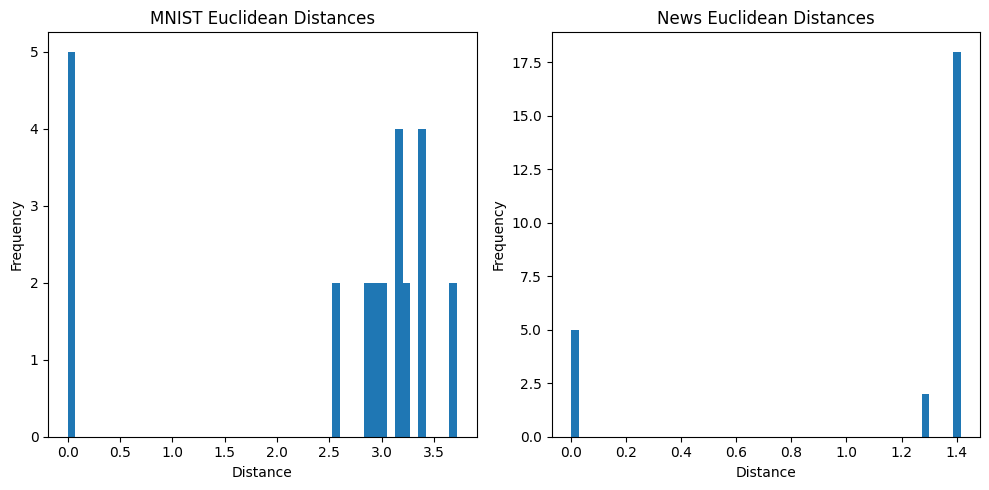


Splitting datasets...

MNIST Results:
Training Accuracy: 0.9896
Validation Accuracy: 0.9778
Test Accuracy: 0.9944

MNIST Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        23
           5       1.00      0.95      0.97        20
           6       0.92      1.00      0.96        12
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        17

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [ ]:
# Cell 9 - Main Execution
def main():
    # Load datasets
    print("Loading and preprocessing datasets...")
    mnist_features, mnist_labels = load_mnist()

    # Take a subset of MNIST data for faster processing
    subset_size = 10000
    mnist_features = mnist_features[:subset_size]
    mnist_labels = mnist_labels[:subset_size]

    texts, news_labels = load_20ng()
    news_features = preprocess_20ng_for_similarity(texts)

    # Compute comprehensive distances
    distance_results = compute_comprehensive_distances(mnist_features, texts, news_features)

    # Split datasets into train/val/test (80/10/10)
    print("\nSplitting datasets...")

    # MNIST splits
    X_train_mnist, X_temp_mnist, y_train_mnist, y_temp_mnist = train_test_split(
        mnist_features, mnist_labels, test_size=0.2, random_state=42
    )
    X_val_mnist, X_test_mnist, y_val_mnist, y_test_mnist = train_test_split(
        X_temp_mnist, y_temp_mnist, test_size=0.5, random_state=42
    )

    # News splits
    X_train_news, X_temp_news, y_train_news, y_temp_news = train_test_split(
        news_features, news_labels, test_size=0.2, random_state=42
    )
    X_val_news, X_test_news, y_val_news, y_test_news = train_test_split(
        X_temp_news, y_temp_news, test_size=0.5, random_state=42
    )

    # Initialize and evaluate classifiers
    mnist_clf = CustomKNNClassifier(n_neighbors=5)
    news_clf = CustomKNNClassifier(n_neighbors=5)

    mnist_results = evaluate_classifier(
        mnist_clf,
        X_train_mnist, X_val_mnist, X_test_mnist,
        y_train_mnist, y_val_mnist, y_test_mnist,
        "MNIST"
    )

    news_results = evaluate_classifier(
        news_clf,
        X_train_news, X_val_news, X_test_news,
        y_train_news, y_val_news, y_test_news,
        "20 Newsgroups"
    )

    # Visualize classification results
    visualize_results(mnist_results, news_results)

# Cell 10 - Run Main (Optional)
if __name__ == "__main__":
    main()